In [58]:
%pip install pyomo
!apt-get install -y coinor-cbc  # Instalar o solver CBC no Colab


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


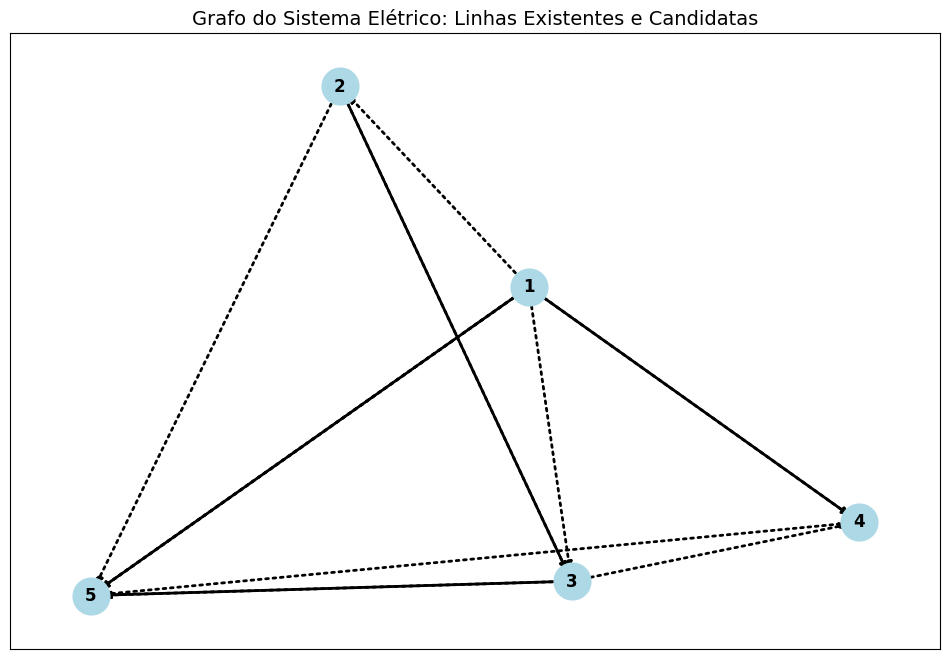

In [59]:
import networkx as nx
import matplotlib.pyplot as plt

# Tabela de linhas do sistema elétrico
lines = [
    {"from": 1, "to": 2, "state": 0, "capacity": 200, "cost": 4000000},
    {"from": 1, "to": 3, "state": 0, "capacity": 200, "cost": 3800000},
    {"from": 1, "to": 4, "state": 1, "capacity": 200, "cost": 0},
    {"from": 1, "to": 4, "state": 0, "capacity": 200, "cost": 6000000},
    {"from": 1, "to": 5, "state": 1, "capacity": 100, "cost": 0},
    {"from": 1, "to": 5, "state": 0, "capacity": 100, "cost": 3000000},
    {"from": 1, "to": 5, "state": 0, "capacity": 100, "cost": 3000000},
    {"from": 2, "to": 3, "state": 1, "capacity": 200, "cost": 0},
    {"from": 2, "to": 3, "state": 0, "capacity": 200, "cost": 2000000},
    {"from": 2, "to": 5, "state": 0, "capacity": 200, "cost": 3100000},
    {"from": 3, "to": 4, "state": 0, "capacity": 250, "cost": 6000000},
    {"from": 3, "to": 5, "state": 1, "capacity": 150, "cost": 0},
    {"from": 3, "to": 5, "state": 0, "capacity": 150, "cost": 2000000},
    {"from": 4, "to": 5, "state": 0, "capacity": 200, "cost": 6300000},
]

# Criação do grafo
G = nx.MultiDiGraph()

# Adicionando linhas ao grafo
for line in lines:
    G.add_edge(
        line["from"], line["to"],
        state=line["state"],
        capacity=line["capacity"],
        cost=line["cost"]
    )

# Função para deslocar arestas paralelas
def shift_edge_position(pos, edge, offset):
    u, v = edge
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    dx = x2 - x1
    dy = y2 - y1
    length = (dx**2 + dy**2)**0.5
    # Vetor ortogonal normalizado
    ox = -dy / length
    oy = dx / length
    # Novo ponto deslocado
    return ((x1 + x2) / 2 + offset * ox, (y1 + y2) / 2 + offset * oy)

# Visualização do grafo do sistema elétrico
plt.figure(figsize=(12, 8))

# Posicionamento das barras (nós)
pos = nx.spring_layout(G)

# Desenhar as barras (nós)
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")

# Criar listas de arestas
edges_state_1 = [(u, v) for u, v, d in G.edges(data=True) if d["state"] == 1]
edges_state_0 = [(u, v) for u, v, d in G.edges(data=True) if d["state"] == 0]

# Desenhar arestas existentes (state == 1) como pretas sólidas
nx.draw_networkx_edges(
    G, pos, edgelist=edges_state_1, edge_color="black", style="solid", width=2
)

# Desenhar arestas candidatas (state == 0) como pontilhadas deslocadas
nx.draw_networkx_edges(
    G, pos, edgelist=edges_state_0, edge_color="black", style="dotted", width=2
)

# Adicionar rótulos às barras
nx.draw_networkx_labels(G, pos, font_size=12, font_color="black", font_weight="bold")

# Adicionar título ao grafo
plt.title("Grafo do Sistema Elétrico: Linhas Existentes e Candidatas", fontsize=14)
plt.show()


In [66]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory

# Definição do sistema elétrico (linhas)
lines = [
    {"from": 1, "to": 2, "state": 0, "capacity": 200, "cost": 4000000},
    {"from": 1, "to": 3, "state": 0, "capacity": 200, "cost": 3800000},
    {"from": 1, "to": 4, "state": 1, "capacity": 200, "cost": 0},
    {"from": 1, "to": 4, "state": 0, "capacity": 200, "cost": 6000000},
    {"from": 1, "to": 5, "state": 1, "capacity": 100, "cost": 0},
    {"from": 1, "to": 5, "state": 0, "capacity": 100, "cost": 3000000},
    {"from": 1, "to": 5, "state": 0, "capacity": 100, "cost": 3000000},
    {"from": 2, "to": 3, "state": 1, "capacity": 200, "cost": 0},
    {"from": 2, "to": 3, "state": 0, "capacity": 200, "cost": 2000000},
    {"from": 2, "to": 5, "state": 0, "capacity": 200, "cost": 3100000},
    {"from": 3, "to": 4, "state": 0, "capacity": 250, "cost": 6000000},
    {"from": 3, "to": 5, "state": 1, "capacity": 150, "cost": 0},
    {"from": 3, "to": 5, "state": 0, "capacity": 150, "cost": 2000000},
    {"from": 4, "to": 5, "state": 0, "capacity": 200, "cost": 6300000},
]

# Definição dos geradores
generators = [
    {"bus": 1, "state": 1, "Pmax": 600, "cost_op": 70, "cost_invest": 0},
    {"bus": 1, "state": 0, "Pmax": 500, "cost_op": 50, "cost_invest": 35000000},
    {"bus": 3, "state": 1, "Pmax": 200, "cost_op": 60, "cost_invest": 0},
    {"bus": 3, "state": 0, "Pmax": 250, "cost_op": 55, "cost_invest": 15000000},
]

# Demanda projetada
demands = {
    1: [40, 80, 100, 150, 200],
    2: [120, 240, 250, 300, 350],
    3: [20, 40, 50, 100, 150],
    4: [80, 160, 200, 250, 250],
    5: [120, 240, 250, 300, 320],
}

R = 0.2  # Resistência
deficit_cost = 500  # Custo de déficit em US$/MWh

# Inicialização do modelo
def build_model(flow_ref):
    model = ConcreteModel()

    # Conjuntos
    model.T = RangeSet(1, 5)  # Períodos (anos)
    model.BUS = RangeSet(1, 5)  # Barras
    model.LINES = RangeSet(1, len(lines))  # Linhas
    model.GEN = RangeSet(1, len(generators))  # Geradores

    # Variáveis
    model.Pg = Var(model.GEN, model.T, domain=NonNegativeReals)  # Geração
    model.Flow = Var(model.LINES, model.T, domain=Reals)  # Fluxo nas linhas
    model.Deficit = Var(model.BUS, model.T, domain=NonNegativeReals)  # Déficit
    model.z = Var(model.LINES, model.T, domain=NonNegativeReals)  # Perdas aproximadas
    model.LineAvailable = Var(model.LINES, model.T, domain=Binary)  # Disponibilidade de linhas por ano

    # Função objetivo
    model.obj = Objective(
        expr=sum(
            generators[g - 1]["cost_invest"] * model.Pg[g, t]
            for g in model.GEN
            for t in model.T
        )
        + sum(
            generators[g - 1]["cost_op"] * model.Pg[g, t]
            for g in model.GEN
            for t in model.T
        )
        + sum(
            lines[l - 1]["cost"] * model.LineAvailable[l, t]
            for l in model.LINES
            for t in model.T
        )
        + sum(deficit_cost * model.Deficit[b, t] for b in model.BUS for t in model.T)
        + sum(R * model.z[l, t] for l in model.LINES for t in model.T),
        sense=minimize,
    )

    # Restrições de geração
    model.gen_limits = ConstraintList()
    for g in model.GEN:
        for t in model.T:
            model.gen_limits.add(
                model.Pg[g, t] <= generators[g - 1]["Pmax"]
            )

    # Balanço de potência
    model.balance = ConstraintList()
    for t in model.T:
        for b in model.BUS:
            inflow = sum(
                model.Flow[l, t] for l in model.LINES if lines[l - 1]["to"] == b
            )
            outflow = sum(
                model.Flow[l, t] for l in model.LINES if lines[l - 1]["from"] == b
            )
            gen = sum(
                model.Pg[g, t] for g in model.GEN if generators[g - 1]["bus"] == b
            )
            model.balance.add(
                gen + inflow - outflow + model.Deficit[b, t] == demands[b][t - 1]
            )

    # Limites de fluxo e disponibilidade de linha
    model.flow_limits = ConstraintList()
    for l in model.LINES:
        for t in model.T:
            model.flow_limits.add(
                model.Flow[l, t]
                <= lines[l - 1]["capacity"] * model.LineAvailable[l, t]
            )
            model.flow_limits.add(
                model.Flow[l, t]
                >= -lines[l - 1]["capacity"] * model.LineAvailable[l, t]
            )

    # Linearização para perdas
    model.loss_approx = ConstraintList()
    for l in model.LINES:
        for t in model.T:
            model.loss_approx.add(
                model.z[l, t] >= flow_ref[l - 1][t - 1] * model.Flow[l, t]
            )

    return model

# Inicializar aproximações
flow_ref = [[0] * 5 for _ in lines]

# Iteração sucessiva
tolerance = 1e-3

model = build_model(flow_ref)
solver = SolverFactory("cbc")
results = solver.solve(model)
model.display()

# Atualizar aproximação
max_diff = 0
for l in range(len(lines)):
    for t in range(5):
        new_guess = model.Flow[l + 1, t + 1].value
        max_diff = max(max_diff, abs(flow_ref[l][t] - new_guess))
        flow_ref[l][t] = new_guess

# Resultados
generation_results = {
    (g, t): model.Pg[g, t].value for g in model.GEN for t in model.T
}
investment_results_lines = {
    (l, t): (lines[l - 1]["from"], lines[l - 1]["to"], t)
    for l in model.LINES
    for t in model.T
    if model.LineAvailable[l, t].value > 0.5
}
investment_results_gens = {g: generators[g - 1]["cost_invest"] for g in model.GEN if generators[g - 1]["state"] == 0}
deficit_results = {
    (b, t): model.Deficit[b, t].value for b in model.BUS for t in model.T
}


# 1. Data Frame com a geração dos geradores
df_generation = pd.DataFrame([
    {"Gerador": g, "Ano": t, "Geração (MW)": generation_results[(g, t)]}
    for g, t in generation_results
])

# 2. Data Frame com o fluxo das linhas
df_lines = pd.DataFrame([
    {
        "Linha": l,
        "Origem": lines[l - 1]["from"],
        "Destino": lines[l - 1]["to"],
        "Ano": t,
        "Fluxo (MW)": model.Flow[l, t].value
    }
    for l in range(1, len(lines) + 1)
    for t in range(1, 6)
])

# 3. Data Frame com as barras
df_buses = pd.DataFrame([
    {
        "Barra": b,
        "Ano": t,
        "Demanda (MW)": demands[b][t - 1],
        "Geração Disponível (MW)": sum(
            model.Pg[g, t].value
            for g in range(1, len(generators) + 1)
            if generators[g - 1]["bus"] == b
        ),
        "Déficit (MW)": model.Deficit[b, t].value
    }
    for b in range(1, len(demands) + 1)
    for t in range(1, 6)
])

# Mostrar os data frames gerados
print("Geração por Gerador por Ano:")
print(df_generation)

print("\nFluxo nas Linhas por Ano:")
print(df_lines)

print("\nResultados por Barra por Ano:")
print(df_buses)

print("Geração ótima (MW):", generation_results)
print("Investimentos em linhas (Origem, Destino, Ano):", investment_results_lines)
print("Investimentos em geradores:", investment_results_gens)
print("Déficit em MW:", deficit_results)


Model unknown

  Variables:
    Pg : Size=20, Index=GEN*T
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1) :     0 : 180.0 :  None : False : False : NonNegativeReals
        (1, 2) :     0 : 340.0 :  None : False : False : NonNegativeReals
        (1, 3) :     0 : 400.0 :  None : False : False : NonNegativeReals
        (1, 4) :     0 : 450.0 :  None : False : False : NonNegativeReals
        (1, 5) :     0 : 500.0 :  None : False : False : NonNegativeReals
        (2, 1) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 2) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 4) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 5) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (3, 1) :     0 : 200.0 :  None : False : False : NonNegativeReals
        (3, 2) :     0 : 200.0 :  None : False : False : NonNega

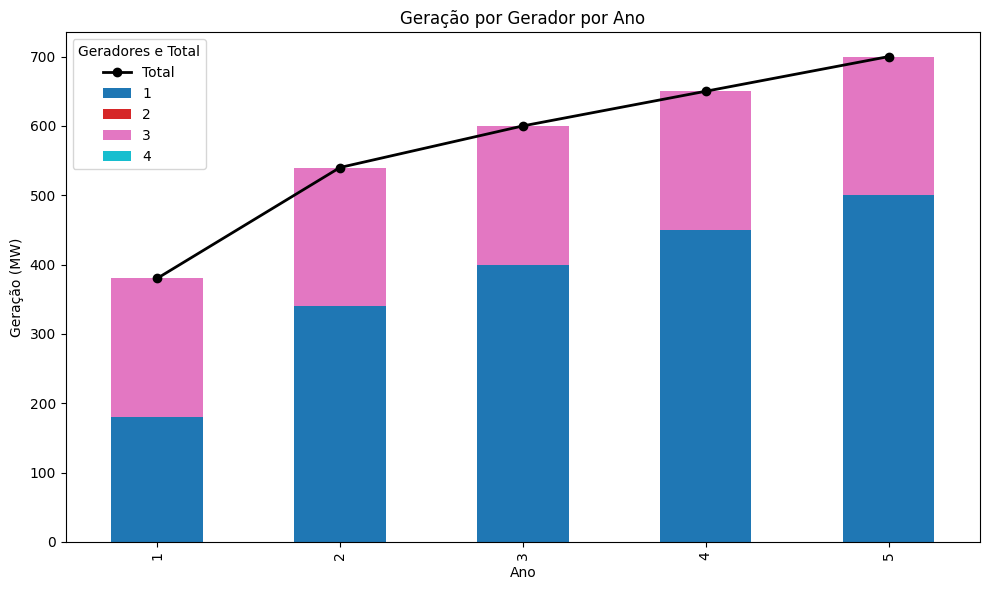

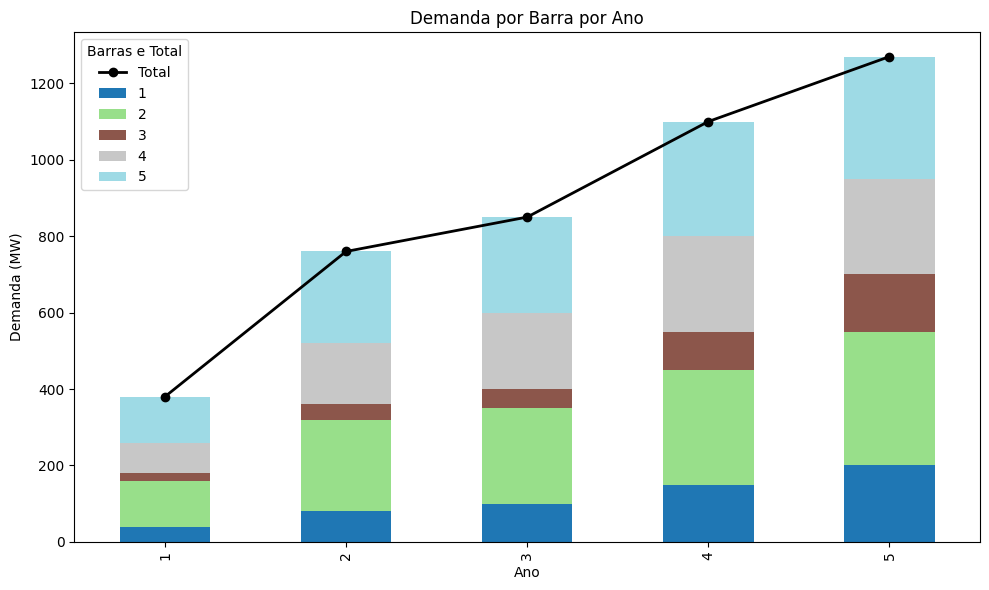

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# Usando os DataFrames criados anteriormente
# Geração por gerador (df_generation)
# Resultados por barra (df_buses)

# 1. Gráfico de Geração por Gerador por Ano
# Preparar os dados
df_gen_pivot = df_generation.pivot(index='Ano', columns='Gerador', values='Geração (MW)')
df_gen_pivot['Total'] = df_gen_pivot.sum(axis=1)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
df_gen_pivot.drop(columns='Total').plot(kind='bar', stacked=True, ax=ax, colormap='tab10')
ax.plot(df_gen_pivot.index-1, df_gen_pivot['Total'], color='black', linewidth=2, marker='o', label='Total')
ax.set_title("Geração por Gerador por Ano")
ax.set_xlabel("Ano")
ax.set_ylabel("Geração (MW)")
ax.legend(title="Geradores e Total", loc="upper left")
plt.tight_layout()
plt.show()

# 2. Gráfico de Demanda por Barra por Ano
# Preparar os dados
df_buses_pivot = df_buses.pivot(index='Ano', columns='Barra', values='Demanda (MW)')
df_buses_pivot['Total'] = df_buses_pivot.sum(axis=1)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
df_buses_pivot.drop(columns='Total').plot(kind='bar', stacked=True, ax=ax, colormap='tab20')
ax.plot(df_buses_pivot.index-1, df_buses_pivot['Total'], color='black', linewidth=2, marker='o', label='Total')
ax.set_title("Demanda por Barra por Ano")
ax.set_xlabel("Ano")
ax.set_ylabel("Demanda (MW)")
ax.legend(title="Barras e Total", loc="upper left")
plt.tight_layout()
plt.show()


In [67]:
import pandas as pd
from pyomo.environ import *

# Definição do sistema elétrico (linhas)
lines = [
    {"from": 1, "to": 2, "state": 0, "capacity": 200, "cost": 4000000, "X": 0.1},
    {"from": 1, "to": 3, "state": 0, "capacity": 200, "cost": 3800000, "X": 0.1},
    {"from": 1, "to": 4, "state": 1, "capacity": 200, "cost": 0, "X": 0.1},
    {"from": 1, "to": 4, "state": 0, "capacity": 200, "cost": 6000000, "X": 0.1},
    {"from": 1, "to": 5, "state": 1, "capacity": 100, "cost": 0, "X": 0.1},
    {"from": 1, "to": 5, "state": 0, "capacity": 100, "cost": 3000000, "X": 0.1},
    {"from": 1, "to": 5, "state": 0, "capacity": 100, "cost": 3000000, "X": 0.1},
    {"from": 2, "to": 3, "state": 1, "capacity": 200, "cost": 0, "X": 0.1},
    {"from": 2, "to": 3, "state": 0, "capacity": 200, "cost": 2000000, "X": 0.1},
    {"from": 2, "to": 5, "state": 0, "capacity": 200, "cost": 3100000, "X": 0.1},
    {"from": 3, "to": 4, "state": 0, "capacity": 250, "cost": 6000000, "X": 0.1},
    {"from": 3, "to": 5, "state": 1, "capacity": 150, "cost": 0, "X": 0.1},
    {"from": 3, "to": 5, "state": 0, "capacity": 150, "cost": 2000000, "X": 0.1},
    {"from": 4, "to": 5, "state": 0, "capacity": 200, "cost": 6300000, "X": 0.1},
]

# Definição dos geradores
generators = [
    {"bus": 1, "state": 1, "Pmax": 600, "cost_op": 70, "cost_invest": 0},
    {"bus": 1, "state": 0, "Pmax": 500, "cost_op": 50, "cost_invest": 35000000},
    {"bus": 3, "state": 1, "Pmax": 200, "cost_op": 60, "cost_invest": 0},
    {"bus": 3, "state": 0, "Pmax": 250, "cost_op": 55, "cost_invest": 15000000},
]

# Demanda projetada
demands = {
    1: [40, 80, 100, 150, 200],
    2: [120, 240, 250, 300, 350],
    3: [20, 40, 50, 100, 150],
    4: [80, 160, 200, 250, 250],
    5: [120, 240, 250, 300, 320],
}

deficit_cost = 150000  # Custo de déficit em US$/MWh

# Inicialização do modelo
def build_model():
    model = ConcreteModel()

    # Conjuntos
    model.T = RangeSet(1, 5)  # Períodos (anos)
    model.BUS = RangeSet(1, 5)  # Barras
    model.LINES = RangeSet(1, len(lines))  # Linhas
    model.GEN = RangeSet(1, len(generators))  # Geradores

    # Variáveis
    model.Pg = Var(model.GEN, model.T, domain=NonNegativeReals)  # Geração
    model.Flow = Var(model.LINES, model.T, domain=Reals)  # Fluxo nas linhas
    model.Deficit = Var(model.BUS, model.T, domain=NonNegativeReals)  # Déficit
    model.DeltaTheta = Var(model.BUS, model.T, domain=Reals)  # Diferença de ângulo
    #model.LineAvailable = Var(model.LINES, model.T, domain=Binary)  # Disponibilidade de linhas por ano
    model.LineAvailable = Var(model.LINES, model.T, domain=Binary)

    for l in range(1, len(lines) + 1):
        if lines[l - 1]["state"] == 1:  # Linha existente
            for t in range(1, 6):
                model.LineAvailable[l, t].fix(1)  # Fixar como disponível

    # Função objetivo
    model.obj = Objective(
        expr=sum(
            generators[g - 1]["cost_invest"] * model.Pg[g, t]
            for g in model.GEN
            for t in model.T
        )
        + sum(
            generators[g - 1]["cost_op"] * model.Pg[g, t]
            for g in model.GEN
            for t in model.T
        )
        + sum(
            lines[l - 1]["cost"] * model.LineAvailable[l, t]
            for l in model.LINES
            for t in model.T
            if lines[l - 1]["state"] == 0
        )
        + sum(deficit_cost * model.Deficit[b, t] for b in model.BUS for t in model.T),
        sense=minimize,
    )

    # Restrições de geração
    model.gen_limits = ConstraintList()
    for g in model.GEN:
        for t in model.T:
            model.gen_limits.add(
                model.Pg[g, t] <= generators[g - 1]["Pmax"]
            )

    # Balanço de potência
    model.balance = ConstraintList()
    for t in model.T:
      for b in model.BUS:
        inflow = sum(
            model.Flow[l, t] for l in model.LINES if lines[l - 1]["to"] == b
        )
        outflow = sum(
            model.Flow[l, t] for l in model.LINES if lines[l - 1]["from"] == b
        )
        gen = sum(
            model.Pg[g, t] for g in model.GEN if generators[g - 1]["bus"] == b
        )
        model.balance.add(
            gen + inflow - outflow + model.Deficit[b, t] == demands[b][t - 1]
        )


    # Fluxo de potência DC
    """model.flow_dc = ConstraintList()
    for l in model.LINES:
        for t in model.T:
            model.flow_dc.add(
                model.Flow[l, t]
                == (model.DeltaTheta[lines[l - 1]["from"], t] - model.DeltaTheta[lines[l - 1]["to"], t])
                / lines[l - 1]["X"]
            )"""

    # Limites de ângulo
    delta_max = 0.5  # Limite de ângulo em radianos
    model.angle_limits = ConstraintList()
    for b in model.BUS:
        for t in model.T:
            model.angle_limits.add(model.DeltaTheta[b, t] >= -delta_max)
            model.angle_limits.add(model.DeltaTheta[b, t] <= delta_max)

    # Limites de fluxo
    model.flow_limits = ConstraintList()
    for l in model.LINES:
        for t in model.T:
            model.flow_limits.add(
                model.Flow[l, t]
                <= lines[l - 1]["capacity"] * model.LineAvailable[l, t]
            )
            model.flow_limits.add(
                model.Flow[l, t]
                >= -lines[l - 1]["capacity"] * model.LineAvailable[l, t]
            )

    return model

# Criação e solução do modelo
model = build_model()
solver = SolverFactory("cbc")
results = solver.solve(model)
model.display()
# Resultados
generation_results = {
    (g, t): model.Pg[g, t].value for g in model.GEN for t in model.T
}
investment_results_lines = {
    (l, t): (lines[l - 1]["from"], lines[l - 1]["to"], t)
    for l in model.LINES
    for t in model.T
    if model.LineAvailable[l, t].value > 0.5
}
investment_results_gens = {g: generators[g - 1]["cost_invest"] for g in model.GEN if generators[g - 1]["state"] == 0}
deficit_results = {
    (b, t): model.Deficit[b, t].value for b in model.BUS for t in model.T
}

# 1. Data Frame com a geração dos geradores
df_generation = pd.DataFrame([
    {"Gerador": g, "Ano": t, "Geração (MW)": generation_results[(g, t)]}
    for g, t in generation_results
])

# 2. Data Frame com o fluxo das linhas
# DataFrame com o fluxo otimizado nas linhas
df_lines = pd.DataFrame([
    {
        "Linha": l,
        "Origem": lines[l - 1]["from"],
        "Destino": lines[l - 1]["to"],
        "Ano": t,
        "Fluxo (MW)": model.Flow[l, t].value if model.Flow[l, t].value is not None else 0.0
    }
    for l in range(1, len(lines) + 1)
    for t in range(1, 6)
])

# Configurar pandas para exibir todas as linhas do DataFrame
pd.set_option('display.max_rows', None)

# Exibir o DataFrame completo
print("\nFluxo nas Linhas por Ano:")
print(df_lines)

for g in model.GEN:
    for t in model.T:
        print(f"Teste Gerador {g}, Ano {t}: Geração = {model.Pg[g, t].value}")

# 3. Data Frame com as barras
df_buses = pd.DataFrame([
    {
        "Barra": b,
        "Ano": t,
        "Demanda (MW)": demands[b][t - 1],
        "Geração Disponível (MW)": sum(
            model.Pg[g, t].value
            for g in range(1, len(generators) + 1)
            if generators[g - 1]["bus"] == b
        ),
        "Déficit (MW)": model.Deficit[b, t].value
    }
    for b in range(1, len(demands) + 1)
    for t in range(1, 6)
])

# Mostrar os data frames gerados
print("Geração por Gerador por Ano:")
print(df_generation)

print("\nResultados por Barra por Ano:")
print(df_buses)

print("Geração ótima (MW):", generation_results)
print("Investimentos em linhas (Origem, Destino, Ano):", investment_results_lines)
print("Investimentos em geradores:", investment_results_gens)
print("Déficit em MW:", deficit_results)

print("Verificação dos fluxos:")
for l in range(1, len(lines) + 1):
    for t in range(1, 6):
        print(f"Linha {l} (Origem: {lines[l - 1]['from']}, Destino: {lines[l - 1]['to']}), Ano {t}: Fluxo = {model.Flow[l, t].value}")

print("Verificação do balanço de potência por barra:")
for b in range(1, len(demands) + 1):
    for t in range(1, 6):
        inflow = sum(
            model.Flow[l, t].value for l in range(1, len(lines) + 1) if lines[l - 1]["to"] == b
        )
        outflow = sum(
            model.Flow[l, t].value for l in range(1, len(lines) + 1) if lines[l - 1]["from"] == b
        )
        gen = sum(
            model.Pg[g, t].value for g in range(1, len(generators) + 1) if generators[g - 1]["bus"] == b
        )
        deficit = model.Deficit[b, t].value
        print(f"Barra {b}, Ano {t}: Geração = {gen}, Demanda = {demands[b][t - 1]}, Inflow = {inflow}, Outflow = {outflow}, Déficit = {deficit}")


print("Linhas existentes e sua disponibilidade:")
for l in range(1, len(lines) + 1):
    if lines[l - 1]["state"] == 1:
        print(f"Linha {l}: Disponível = {[model.LineAvailable[l, t].value for t in range(1, 6)]}")
print("Geração por barra:")
for b in range(1, len(demands) + 1):
    for t in range(1, 6):
        print(f"Barra {b}, Ano {t}: Geração = {sum(model.Pg[g, t].value for g in range(1, len(generators) + 1) if generators[g - 1]['bus'] == b)}")




Model unknown

  Variables:
    Pg : Size=20, Index=GEN*T
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1) :     0 : 180.0 :  None : False : False : NonNegativeReals
        (1, 2) :     0 : 540.0 :  None : False : False : NonNegativeReals
        (1, 3) :     0 : 600.0 :  None : False : False : NonNegativeReals
        (1, 4) :     0 : 600.0 :  None : False : False : NonNegativeReals
        (1, 5) :     0 : 600.0 :  None : False : False : NonNegativeReals
        (2, 1) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 2) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 4) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 5) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (3, 1) :     0 : 200.0 :  None : False : False : NonNegativeReals
        (3, 2) :     0 : 200.0 :  None : False : False : NonNega

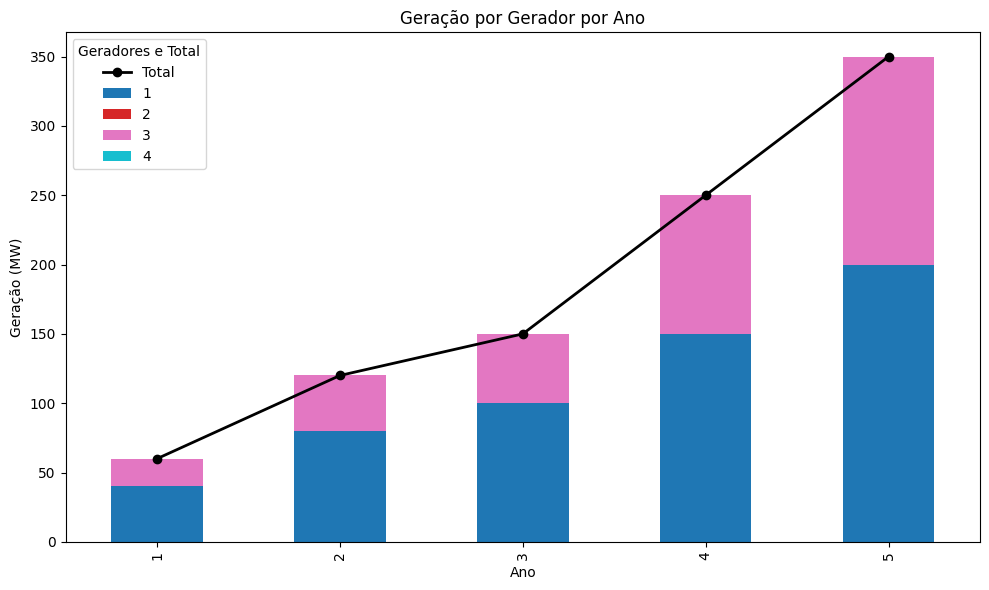

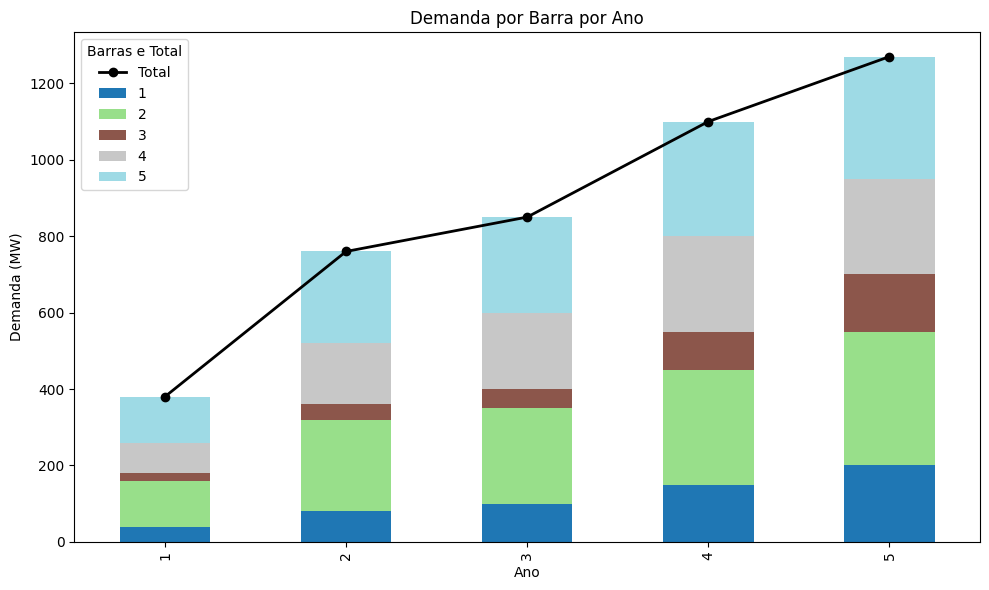

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Usando os DataFrames criados anteriormente
# Geração por gerador (df_generation)
# Resultados por barra (df_buses)

# 1. Gráfico de Geração por Gerador por Ano
# Preparar os dados
df_gen_pivot = df_generation.pivot(index='Ano', columns='Gerador', values='Geração (MW)')
df_gen_pivot['Total'] = df_gen_pivot.sum(axis=1)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
df_gen_pivot.drop(columns='Total').plot(kind='bar', stacked=True, ax=ax, colormap='tab10')
ax.plot(df_gen_pivot.index-1, df_gen_pivot['Total'], color='black', linewidth=2, marker='o', label='Total')
ax.set_title("Geração por Gerador por Ano")
ax.set_xlabel("Ano")
ax.set_ylabel("Geração (MW)")
ax.legend(title="Geradores e Total", loc="upper left")
plt.tight_layout()
plt.show()

# 2. Gráfico de Demanda por Barra por Ano
# Preparar os dados
df_buses_pivot = df_buses.pivot(index='Ano', columns='Barra', values='Demanda (MW)')
df_buses_pivot['Total'] = df_buses_pivot.sum(axis=1)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
df_buses_pivot.drop(columns='Total').plot(kind='bar', stacked=True, ax=ax, colormap='tab20')
ax.plot(df_buses_pivot.index-1, df_buses_pivot['Total'], color='black', linewidth=2, marker='o', label='Total')
ax.set_title("Demanda por Barra por Ano")
ax.set_xlabel("Ano")
ax.set_ylabel("Demanda (MW)")
ax.legend(title="Barras e Total", loc="upper left")
plt.tight_layout()
plt.show()
